# Imports

In [1]:
import matplotlib.pyplot as plt
from loadfile import *
from phonemes import *
from preprocess import *
from evaluate import *
from google_kb_z_speaker.main import *
from tqdm.auto import tqdm
from experiment_helpers import *
from functools import partial
import numpy as np
import logging
from seqmatch import *
from main import *
from google_kb_z_speaker.experiments import *
from google_kb_z_speaker.preprocessing import *
import pickle
import random
import shutil 
import codecs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Text processing

In [58]:
def convert_iso_to_utf(sourceFileName):
    BLOCKSIZE = 1048576  # or some other, desired size in bytes
    with codecs.open(sourceFileName, "r", "ISO-8859-1") as sourceFile:
        with codecs.open(sourceFileName + ".converted", "w", "utf-8") as targetFile:
            while True:
                contents = sourceFile.read(BLOCKSIZE)
                if not contents:
                    break
                targetFile.write(contents)
    shutil.move(sourceFileName + ".converted", sourceFileName)

In [4]:
read_speech_dir = "/data/sisters/maggan_read"
dialogue_speech_dir = "/data/sisters/maggan_dialogue"
curr_speech_dir = read_speech_dir
speech_type = os.path.basename(curr_speech_dir)

In [5]:
speaker_paths = [ os.path.join(curr_speech_dir, x) for x in os.listdir(curr_speech_dir) if x.startswith("z")]

In [61]:
for sp in speaker_paths:
    for x in os.listdir(sp):
        if "google" in x:
            shutil.copy(os.path.join(sp,x), os.path.join("output",speech_type,x))
            if speech_type == "maggan_dialogue":
                convert_iso_to_utf( os.path.join("output",speech_type,x))
        if "correct" in x:
            shutil.copy(os.path.join(sp,x), os.path.join("output",speech_type,x))
            convert_iso_to_utf( os.path.join("output",speech_type,x))

'output/maggan_read/z12.googleasr'

'output/maggan_read/z12.correct'

'output/maggan_read/z3.googleasr'

'output/maggan_read/z3.correct'

'output/maggan_read/z7.googleasr'

'output/maggan_read/z7.correct'

'output/maggan_read/z26.correct'

'output/maggan_read/z26.googleasr'

'output/maggan_read/z6.correct'

'output/maggan_read/z6.googleasr'

'output/maggan_read/z17.correct'

'output/maggan_read/z17.googleasr'

'output/maggan_read/z22.googleasr'

'output/maggan_read/z22.correct'

'output/maggan_read/z25.googleasr'

'output/maggan_read/z25.correct'

'output/maggan_read/z14.googleasr'

'output/maggan_read/z14.correct'

'output/maggan_read/z8.googleasr'

'output/maggan_read/z8.correct'

'output/maggan_read/z5.googleasr'

'output/maggan_read/z5.correct'

'output/maggan_read/z18.correct'

'output/maggan_read/z18.googleasr'

'output/maggan_read/z15.googleasr'

'output/maggan_read/z15.correct'

'output/maggan_read/z23.googleasr'

'output/maggan_read/z23.correct'

'output/maggan_read/z16.googleasr'

'output/maggan_read/z16.correct'

'output/maggan_read/z13.correct'

'output/maggan_read/z13.googleasr'

'output/maggan_read/z9.correct'

'output/maggan_read/z9.googleasr'

In [ ]:
for d in tqdm(speaker_dirs):
    speaker_name = os.path.basename(d)
    output_path = os.path.join("output",speech_type, speaker_name + ".kb")
    print(f"Transcribing {speaker_name} with output path {output_path}")
    transcribe_directory_of_wav_files(d, output_path)

  0%|          | 0/17 [00:00<?, ?it/s]

Transcribing z12 with output path output/maggan_read/z12.kb


  0%|          | 0/273 [00:00<?, ?it/s]

2022-03-22 15:23:51,077.77 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z12/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:23:51,580.580 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:23:51,590.590 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:23:52,085.85 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:23:52,095.95 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:23:52,581.581 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:23:52,591.591 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:23:53,087.87 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-

Transcribing file  /data/sisters/maggan_read/z12/file_127.wav
Transcribing file  /data/sisters/maggan_read/z12/file_133.wav
Transcribing file  /data/sisters/maggan_read/z12/file_11.wav
Transcribing file  /data/sisters/maggan_read/z12/file_46.wav
Transcribing file  /data/sisters/maggan_read/z12/file_27.wav
Transcribing file  /data/sisters/maggan_read/z12/file_71.wav
Transcribing file  /data/sisters/maggan_read/z12/file_56.wav
Transcribing file  /data/sisters/maggan_read/z12/file_102.wav
Transcribing file  /data/sisters/maggan_read/z12/file_78.wav
Transcribing file  /data/sisters/maggan_read/z12/file_10.wav
Transcribing file  /data/sisters/maggan_read/z12/file_62.wav
Transcribing file  /data/sisters/maggan_read/z12/file_45.wav
Transcribing file  /data/sisters/maggan_read/z12/file_120.wav
Transcribing file  /data/sisters/maggan_read/z12/file_23.wav
Transcribing file  /data/sisters/maggan_read/z12/file_13.wav
Transcribing file  /data/sisters/maggan_read/z12/file_2.wav
Transcribing file  /d

  0%|          | 0/93 [00:00<?, ?it/s]

2022-03-22 15:24:04,547.547 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z3/file_11.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:24:05,039.39 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:24:05,048.48 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:05,530.530 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:05,533.533 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:06,019.19 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:06,027.27 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:06,510.510 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-2

Transcribing file  /data/sisters/maggan_read/z3/file_27.wav
Transcribing file  /data/sisters/maggan_read/z3/file_10.wav
Transcribing file  /data/sisters/maggan_read/z3/file_23.wav
Transcribing file  /data/sisters/maggan_read/z3/file_13.wav
Transcribing file  /data/sisters/maggan_read/z3/file_2.wav
Transcribing file  /data/sisters/maggan_read/z3/file_28.wav
Transcribing file  /data/sisters/maggan_read/z3/file_21.wav
Transcribing file  /data/sisters/maggan_read/z3/file_15.wav
Transcribing file  /data/sisters/maggan_read/z3/file_4.wav
Transcribing file  /data/sisters/maggan_read/z3/file_41.wav
Transcribing file  /data/sisters/maggan_read/z3/file_38.wav
Transcribing file  /data/sisters/maggan_read/z3/file_6.wav
Transcribing file  /data/sisters/maggan_read/z3/file_5.wav
Transcribing file  /data/sisters/maggan_read/z3/file_22.wav
Transcribing file  /data/sisters/maggan_read/z3/file_25.wav
Transcribing file  /data/sisters/maggan_read/z3/file_18.wav
Transcribing file  /data/sisters/maggan_read

  0%|          | 0/271 [00:00<?, ?it/s]

2022-03-22 15:24:12,844.844 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z7/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:24:13,349.349 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:24:13,353.353 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:13,836.836 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:13,847.847 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:14,334.334 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:14,342.342 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:14,827.827 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z7/file_127.wav
Transcribing file  /data/sisters/maggan_read/z7/file_11.wav
Transcribing file  /data/sisters/maggan_read/z7/file_46.wav
Transcribing file  /data/sisters/maggan_read/z7/file_27.wav
Transcribing file  /data/sisters/maggan_read/z7/file_71.wav
Transcribing file  /data/sisters/maggan_read/z7/file_56.wav
Transcribing file  /data/sisters/maggan_read/z7/file_102.wav
Transcribing file  /data/sisters/maggan_read/z7/file_78.wav
Transcribing file  /data/sisters/maggan_read/z7/file_10.wav
Transcribing file  /data/sisters/maggan_read/z7/file_62.wav
Transcribing file  /data/sisters/maggan_read/z7/file_45.wav
Transcribing file  /data/sisters/maggan_read/z7/file_120.wav
Transcribing file  /data/sisters/maggan_read/z7/file_23.wav
Transcribing file  /data/sisters/maggan_read/z7/file_13.wav
Transcribing file  /data/sisters/maggan_read/z7/file_2.wav
Transcribing file  /data/sisters/maggan_read/z7/file_94.wav
Transcribing file  /data/sisters/magga

  0%|          | 0/505 [00:00<?, ?it/s]

2022-03-22 15:24:22,760.760 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z26/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:24:23,257.257 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:24:23,270.270 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:23,769.769 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:23,779.779 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:24,276.276 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:24,284.284 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:24,779.779 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z26/file_127.wav
Transcribing file  /data/sisters/maggan_read/z26/file_133.wav
Transcribing file  /data/sisters/maggan_read/z26/file_135.wav
Transcribing file  /data/sisters/maggan_read/z26/file_11.wav
Transcribing file  /data/sisters/maggan_read/z26/file_46.wav
Transcribing file  /data/sisters/maggan_read/z26/file_209.wav
Transcribing file  /data/sisters/maggan_read/z26/file_27.wav
Transcribing file  /data/sisters/maggan_read/z26/file_71.wav
Transcribing file  /data/sisters/maggan_read/z26/file_56.wav
Transcribing file  /data/sisters/maggan_read/z26/file_193.wav
Transcribing file  /data/sisters/maggan_read/z26/file_207.wav
Transcribing file  /data/sisters/maggan_read/z26/file_192.wav
Transcribing file  /data/sisters/maggan_read/z26/file_102.wav
Transcribing file  /data/sisters/maggan_read/z26/file_164.wav
Transcribing file  /data/sisters/maggan_read/z26/file_171.wav
Transcribing file  /data/sisters/maggan_read/z26/file_175.wav
Transcribing 

  0%|          | 0/121 [00:00<?, ?it/s]

2022-03-22 15:24:34,938.938 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z6/file_11.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:24:35,451.451 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:24:35,457.457 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:35,955.955 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:35,961.961 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:36,458.458 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:36,469.469 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:36,968.968 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z6/file_46.wav
Transcribing file  /data/sisters/maggan_read/z6/file_27.wav
Transcribing file  /data/sisters/maggan_read/z6/file_56.wav
Transcribing file  /data/sisters/maggan_read/z6/file_10.wav
Transcribing file  /data/sisters/maggan_read/z6/file_45.wav
Transcribing file  /data/sisters/maggan_read/z6/file_23.wav
Transcribing file  /data/sisters/maggan_read/z6/file_13.wav
Transcribing file  /data/sisters/maggan_read/z6/file_2.wav
Transcribing file  /data/sisters/maggan_read/z6/file_28.wav
Transcribing file  /data/sisters/maggan_read/z6/file_49.wav
Transcribing file  /data/sisters/maggan_read/z6/file_54.wav
Transcribing file  /data/sisters/maggan_read/z6/file_50.wav
Transcribing file  /data/sisters/maggan_read/z6/file_21.wav
Transcribing file  /data/sisters/maggan_read/z6/file_15.wav
Transcribing file  /data/sisters/maggan_read/z6/file_4.wav
Transcribing file  /data/sisters/maggan_read/z6/file_41.wav
Transcribing file  /data/sisters/maggan_re

  0%|          | 0/347 [00:00<?, ?it/s]

2022-03-22 15:24:43,180.180 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z17/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:24:43,673.673 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:24:43,684.684 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:44,176.176 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:44,187.187 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:44,687.687 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:44,697.697 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:45,193.193 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z17/file_127.wav
Transcribing file  /data/sisters/maggan_read/z17/file_133.wav
Transcribing file  /data/sisters/maggan_read/z17/file_135.wav
Transcribing file  /data/sisters/maggan_read/z17/file_11.wav
Transcribing file  /data/sisters/maggan_read/z17/file_46.wav
Transcribing file  /data/sisters/maggan_read/z17/file_27.wav
Transcribing file  /data/sisters/maggan_read/z17/file_71.wav
Transcribing file  /data/sisters/maggan_read/z17/file_56.wav
Transcribing file  /data/sisters/maggan_read/z17/file_102.wav
Transcribing file  /data/sisters/maggan_read/z17/file_164.wav
Transcribing file  /data/sisters/maggan_read/z17/file_78.wav
Transcribing file  /data/sisters/maggan_read/z17/file_10.wav
Transcribing file  /data/sisters/maggan_read/z17/file_62.wav
Transcribing file  /data/sisters/maggan_read/z17/file_45.wav
Transcribing file  /data/sisters/maggan_read/z17/file_120.wav
Transcribing file  /data/sisters/maggan_read/z17/file_162.wav
Transcribing file

  0%|          | 0/317 [00:00<?, ?it/s]

2022-03-22 15:24:53,922.922 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z22/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:24:54,423.423 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:24:54,431.431 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:54,915.915 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:54,918.918 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:55,401.401 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:24:55,409.409 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:24:55,892.892 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z22/file_127.wav
Transcribing file  /data/sisters/maggan_read/z22/file_133.wav
Transcribing file  /data/sisters/maggan_read/z22/file_135.wav
Transcribing file  /data/sisters/maggan_read/z22/file_11.wav
Transcribing file  /data/sisters/maggan_read/z22/file_46.wav
Transcribing file  /data/sisters/maggan_read/z22/file_27.wav
Transcribing file  /data/sisters/maggan_read/z22/file_71.wav
Transcribing file  /data/sisters/maggan_read/z22/file_56.wav
Transcribing file  /data/sisters/maggan_read/z22/file_102.wav
Transcribing file  /data/sisters/maggan_read/z22/file_78.wav
Transcribing file  /data/sisters/maggan_read/z22/file_10.wav
Transcribing file  /data/sisters/maggan_read/z22/file_62.wav
Transcribing file  /data/sisters/maggan_read/z22/file_45.wav
Transcribing file  /data/sisters/maggan_read/z22/file_120.wav
Transcribing file  /data/sisters/maggan_read/z22/file_23.wav
Transcribing file  /data/sisters/maggan_read/z22/file_13.wav
Transcribing file  

  0%|          | 0/317 [00:00<?, ?it/s]

2022-03-22 15:25:03,699.699 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z25/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:25:04,205.205 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:25:04,217.217 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:04,720.720 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:04,728.728 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:05,225.225 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:05,236.236 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:05,720.720 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z25/file_127.wav
Transcribing file  /data/sisters/maggan_read/z25/file_133.wav
Transcribing file  /data/sisters/maggan_read/z25/file_135.wav
Transcribing file  /data/sisters/maggan_read/z25/file_11.wav
Transcribing file  /data/sisters/maggan_read/z25/file_46.wav
Transcribing file  /data/sisters/maggan_read/z25/file_27.wav
Transcribing file  /data/sisters/maggan_read/z25/file_71.wav
Transcribing file  /data/sisters/maggan_read/z25/file_56.wav
Transcribing file  /data/sisters/maggan_read/z25/file_102.wav
Transcribing file  /data/sisters/maggan_read/z25/file_78.wav
Transcribing file  /data/sisters/maggan_read/z25/file_10.wav
Transcribing file  /data/sisters/maggan_read/z25/file_62.wav
Transcribing file  /data/sisters/maggan_read/z25/file_45.wav
Transcribing file  /data/sisters/maggan_read/z25/file_120.wav
Transcribing file  /data/sisters/maggan_read/z25/file_23.wav
Transcribing file  /data/sisters/maggan_read/z25/file_13.wav
Transcribing file  

  0%|          | 0/433 [00:00<?, ?it/s]

2022-03-22 15:25:14,031.31 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z14/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:25:14,531.531 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:25:14,541.541 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:15,027.27 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:15,035.35 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:15,531.531 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:15,541.541 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:16,028.28 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-

Transcribing file  /data/sisters/maggan_read/z14/file_127.wav
Transcribing file  /data/sisters/maggan_read/z14/file_133.wav
Transcribing file  /data/sisters/maggan_read/z14/file_135.wav
Transcribing file  /data/sisters/maggan_read/z14/file_11.wav
Transcribing file  /data/sisters/maggan_read/z14/file_46.wav
Transcribing file  /data/sisters/maggan_read/z14/file_209.wav
Transcribing file  /data/sisters/maggan_read/z14/file_27.wav
Transcribing file  /data/sisters/maggan_read/z14/file_71.wav
Transcribing file  /data/sisters/maggan_read/z14/file_56.wav
Transcribing file  /data/sisters/maggan_read/z14/file_193.wav
Transcribing file  /data/sisters/maggan_read/z14/file_207.wav
Transcribing file  /data/sisters/maggan_read/z14/file_192.wav
Transcribing file  /data/sisters/maggan_read/z14/file_102.wav
Transcribing file  /data/sisters/maggan_read/z14/file_164.wav
Transcribing file  /data/sisters/maggan_read/z14/file_171.wav
Transcribing file  /data/sisters/maggan_read/z14/file_175.wav
Transcribing 

  0%|          | 0/177 [00:00<?, ?it/s]

2022-03-22 15:25:24,842.842 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z8/file_11.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:25:25,329.329 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:25:25,337.337 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:25,824.824 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:25,837.837 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:26,335.335 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:26,348.348 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:26,830.830 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z8/file_46.wav
Transcribing file  /data/sisters/maggan_read/z8/file_27.wav
Transcribing file  /data/sisters/maggan_read/z8/file_71.wav
Transcribing file  /data/sisters/maggan_read/z8/file_56.wav
Transcribing file  /data/sisters/maggan_read/z8/file_78.wav
Transcribing file  /data/sisters/maggan_read/z8/file_10.wav
Transcribing file  /data/sisters/maggan_read/z8/file_62.wav
Transcribing file  /data/sisters/maggan_read/z8/file_45.wav
Transcribing file  /data/sisters/maggan_read/z8/file_23.wav
Transcribing file  /data/sisters/maggan_read/z8/file_13.wav
Transcribing file  /data/sisters/maggan_read/z8/file_2.wav
Transcribing file  /data/sisters/maggan_read/z8/file_85.wav
Transcribing file  /data/sisters/maggan_read/z8/file_28.wav
Transcribing file  /data/sisters/maggan_read/z8/file_49.wav
Transcribing file  /data/sisters/maggan_read/z8/file_54.wav
Transcribing file  /data/sisters/maggan_read/z8/file_50.wav
Transcribing file  /data/sisters/maggan_r

  0%|          | 0/110 [00:00<?, ?it/s]

2022-03-22 15:25:34,044.44 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z5/file_11.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:25:34,529.529 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:25:34,532.532 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:35,016.16 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:35,027.27 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:35,524.524 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:35,532.532 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:36,028.28 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-

Transcribing file  /data/sisters/maggan_read/z5/file_46.wav
Transcribing file  /data/sisters/maggan_read/z5/file_27.wav
Transcribing file  /data/sisters/maggan_read/z5/file_10.wav
Transcribing file  /data/sisters/maggan_read/z5/file_45.wav
Transcribing file  /data/sisters/maggan_read/z5/file_23.wav
Transcribing file  /data/sisters/maggan_read/z5/file_13.wav
Transcribing file  /data/sisters/maggan_read/z5/file_2.wav
Transcribing file  /data/sisters/maggan_read/z5/file_28.wav
Transcribing file  /data/sisters/maggan_read/z5/file_49.wav
Transcribing file  /data/sisters/maggan_read/z5/file_50.wav
Transcribing file  /data/sisters/maggan_read/z5/file_21.wav
Transcribing file  /data/sisters/maggan_read/z5/file_15.wav
Transcribing file  /data/sisters/maggan_read/z5/file_4.wav
Transcribing file  /data/sisters/maggan_read/z5/file_41.wav
Transcribing file  /data/sisters/maggan_read/z5/file_38.wav
Transcribing file  /data/sisters/maggan_read/z5/file_6.wav
Transcribing file  /data/sisters/maggan_rea

  0%|          | 0/75 [00:00<?, ?it/s]

2022-03-22 15:25:42,363.363 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z18/file_11.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:25:42,850.850 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:25:42,859.859 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:43,338.338 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:43,347.347 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:43,829.829 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:43,837.837 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:44,321.321 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z18/file_27.wav
Transcribing file  /data/sisters/maggan_read/z18/file_10.wav
Transcribing file  /data/sisters/maggan_read/z18/file_23.wav
Transcribing file  /data/sisters/maggan_read/z18/file_13.wav
Transcribing file  /data/sisters/maggan_read/z18/file_2.wav
Transcribing file  /data/sisters/maggan_read/z18/file_28.wav
Transcribing file  /data/sisters/maggan_read/z18/file_21.wav
Transcribing file  /data/sisters/maggan_read/z18/file_15.wav
Transcribing file  /data/sisters/maggan_read/z18/file_4.wav
Transcribing file  /data/sisters/maggan_read/z18/file_6.wav
Transcribing file  /data/sisters/maggan_read/z18/file_5.wav
Transcribing file  /data/sisters/maggan_read/z18/file_22.wav
Transcribing file  /data/sisters/maggan_read/z18/file_25.wav
Transcribing file  /data/sisters/maggan_read/z18/file_18.wav
Transcribing file  /data/sisters/maggan_read/z18/file_12.wav
Transcribing file  /data/sisters/maggan_read/z18/file_7.wav
Transcribing file  /data/sist

  0%|          | 0/679 [00:00<?, ?it/s]

2022-03-22 15:25:50,186.186 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z15/file_270.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:25:50,682.682 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:25:50,693.693 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:51,178.178 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:51,189.189 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:51,674.674 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:25:51,685.685 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:25:52,178.178 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z15/file_112.wav
Transcribing file  /data/sisters/maggan_read/z15/file_127.wav
Transcribing file  /data/sisters/maggan_read/z15/file_133.wav
Transcribing file  /data/sisters/maggan_read/z15/file_289.wav
Transcribing file  /data/sisters/maggan_read/z15/file_290.wav
Transcribing file  /data/sisters/maggan_read/z15/file_135.wav
Transcribing file  /data/sisters/maggan_read/z15/file_11.wav
Transcribing file  /data/sisters/maggan_read/z15/file_46.wav
Transcribing file  /data/sisters/maggan_read/z15/file_209.wav
Transcribing file  /data/sisters/maggan_read/z15/file_336.wav
Transcribing file  /data/sisters/maggan_read/z15/file_27.wav
Transcribing file  /data/sisters/maggan_read/z15/file_259.wav
Transcribing file  /data/sisters/maggan_read/z15/file_71.wav
Transcribing file  /data/sisters/maggan_read/z15/file_56.wav
Transcribing file  /data/sisters/maggan_read/z15/file_193.wav
Transcribing file  /data/sisters/maggan_read/z15/file_207.wav
Transcribing 

  0%|          | 0/441 [00:00<?, ?it/s]

2022-03-22 15:26:03,652.652 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z23/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:26:04,147.147 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:26:04,158.158 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:04,640.640 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:04,652.652 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:05,142.142 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:05,153.153 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:05,650.650 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z23/file_127.wav
Transcribing file  /data/sisters/maggan_read/z23/file_133.wav
Transcribing file  /data/sisters/maggan_read/z23/file_135.wav
Transcribing file  /data/sisters/maggan_read/z23/file_11.wav
Transcribing file  /data/sisters/maggan_read/z23/file_46.wav
Transcribing file  /data/sisters/maggan_read/z23/file_209.wav
Transcribing file  /data/sisters/maggan_read/z23/file_27.wav
Transcribing file  /data/sisters/maggan_read/z23/file_71.wav
Transcribing file  /data/sisters/maggan_read/z23/file_56.wav
Transcribing file  /data/sisters/maggan_read/z23/file_193.wav
Transcribing file  /data/sisters/maggan_read/z23/file_207.wav
Transcribing file  /data/sisters/maggan_read/z23/file_192.wav
Transcribing file  /data/sisters/maggan_read/z23/file_102.wav
Transcribing file  /data/sisters/maggan_read/z23/file_164.wav
Transcribing file  /data/sisters/maggan_read/z23/file_171.wav
Transcribing file  /data/sisters/maggan_read/z23/file_175.wav
Transcribing 

  0%|          | 0/507 [00:00<?, ?it/s]

2022-03-22 15:26:14,734.734 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z16/file_112.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:26:15,216.216 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:26:15,226.226 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:15,704.704 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:15,713.713 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:16,209.209 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:16,222.222 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:16,721.721 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z16/file_127.wav
Transcribing file  /data/sisters/maggan_read/z16/file_133.wav
Transcribing file  /data/sisters/maggan_read/z16/file_135.wav
Transcribing file  /data/sisters/maggan_read/z16/file_11.wav
Transcribing file  /data/sisters/maggan_read/z16/file_46.wav
Transcribing file  /data/sisters/maggan_read/z16/file_209.wav
Transcribing file  /data/sisters/maggan_read/z16/file_27.wav
Transcribing file  /data/sisters/maggan_read/z16/file_71.wav
Transcribing file  /data/sisters/maggan_read/z16/file_56.wav
Transcribing file  /data/sisters/maggan_read/z16/file_193.wav
Transcribing file  /data/sisters/maggan_read/z16/file_207.wav
Transcribing file  /data/sisters/maggan_read/z16/file_192.wav
Transcribing file  /data/sisters/maggan_read/z16/file_102.wav
Transcribing file  /data/sisters/maggan_read/z16/file_164.wav
Transcribing file  /data/sisters/maggan_read/z16/file_171.wav
Transcribing file  /data/sisters/maggan_read/z16/file_175.wav
Transcribing 

  0%|          | 0/689 [00:00<?, ?it/s]

2022-03-22 15:26:27,500.500 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z13/file_270.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:26:27,998.998 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:26:28,006.6 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:28,485.485 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:28,493.493 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:28,977.977 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:28,988.988 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:29,475.475 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03

Transcribing file  /data/sisters/maggan_read/z13/file_112.wav
Transcribing file  /data/sisters/maggan_read/z13/file_127.wav
Transcribing file  /data/sisters/maggan_read/z13/file_133.wav
Transcribing file  /data/sisters/maggan_read/z13/file_289.wav
Transcribing file  /data/sisters/maggan_read/z13/file_290.wav
Transcribing file  /data/sisters/maggan_read/z13/file_135.wav
Transcribing file  /data/sisters/maggan_read/z13/file_11.wav
Transcribing file  /data/sisters/maggan_read/z13/file_46.wav
Transcribing file  /data/sisters/maggan_read/z13/file_209.wav
Transcribing file  /data/sisters/maggan_read/z13/file_336.wav
Transcribing file  /data/sisters/maggan_read/z13/file_27.wav
Transcribing file  /data/sisters/maggan_read/z13/file_259.wav
Transcribing file  /data/sisters/maggan_read/z13/file_71.wav
Transcribing file  /data/sisters/maggan_read/z13/file_56.wav
Transcribing file  /data/sisters/maggan_read/z13/file_193.wav
Transcribing file  /data/sisters/maggan_read/z13/file_207.wav
Transcribing 

  0%|          | 0/167 [00:00<?, ?it/s]

2022-03-22 15:26:41,922.922 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z9/file_11.wav
Using model  KBLab/wav2vec2-large-voxrex-swedish


2022-03-22 15:26:42,414.414 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-22 15:26:42,423.423 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:42,905.905 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:42,914.914 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:43,437.437 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-22 15:26:43,445.445 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-22 15:26:43,944.944 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /KBLab/wav2vec2-large-voxrex-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-

Transcribing file  /data/sisters/maggan_read/z9/file_46.wav
Transcribing file  /data/sisters/maggan_read/z9/file_27.wav
Transcribing file  /data/sisters/maggan_read/z9/file_71.wav
Transcribing file  /data/sisters/maggan_read/z9/file_56.wav
Transcribing file  /data/sisters/maggan_read/z9/file_78.wav
Transcribing file  /data/sisters/maggan_read/z9/file_10.wav
Transcribing file  /data/sisters/maggan_read/z9/file_62.wav
Transcribing file  /data/sisters/maggan_read/z9/file_45.wav
Transcribing file  /data/sisters/maggan_read/z9/file_23.wav
Transcribing file  /data/sisters/maggan_read/z9/file_13.wav
Transcribing file  /data/sisters/maggan_read/z9/file_2.wav
Transcribing file  /data/sisters/maggan_read/z9/file_28.wav
Transcribing file  /data/sisters/maggan_read/z9/file_49.wav
Transcribing file  /data/sisters/maggan_read/z9/file_54.wav
Transcribing file  /data/sisters/maggan_read/z9/file_50.wav
Transcribing file  /data/sisters/maggan_read/z9/file_77.wav
Transcribing file  /data/sisters/maggan_r

In [63]:
from distutils.dir_util import copy_tree
copy_tree(f"./output/{speech_type}", f"./transcriptions/{speech_type}")

['./transcriptions/maggan_read/z16.kb',
 './transcriptions/maggan_read/z9.correct',
 './transcriptions/maggan_read/z22.googleasr',
 './transcriptions/maggan_read/z9.googleasr',
 './transcriptions/maggan_read/z5.googleasr',
 './transcriptions/maggan_read/z13.correct',
 './transcriptions/maggan_read/z7.googleasr',
 './transcriptions/maggan_read/z7.kb',
 './transcriptions/maggan_read/z7.correct',
 './transcriptions/maggan_read/z22.correct',
 './transcriptions/maggan_read/z18.correct',
 './transcriptions/maggan_read/z16.googleasr',
 './transcriptions/maggan_read/z15.googleasr',
 './transcriptions/maggan_read/z14.googleasr',
 './transcriptions/maggan_read/z17.correct',
 './transcriptions/maggan_read/z26.correct',
 './transcriptions/maggan_read/z15.kb',
 './transcriptions/maggan_read/z23.kb',
 './transcriptions/maggan_read/z22.kb',
 './transcriptions/maggan_read/z5.kb',
 './transcriptions/maggan_read/z23.googleasr',
 './transcriptions/maggan_read/z26.kb',
 './transcriptions/maggan_read/z18.g

In [50]:
# Speaker dirs
speaker_dirs = [ os.path.join(curr_speech_dir, x) for x in os.listdir(curr_speech_dir) if x.startswith("z")]

In [6]:
bunches = get_bunches("transcriptions", speechType=speech_type)

====Loading data====
Speech type : maggan_read detected speakers {'z15', 'z12', 'z8', 'z7', 'z22', 'z25', 'z13', 'z9', 'z16', 'z17', 'z3', 'z23', 'z5', 'z6', 'z18', 'z26', 'z14'}
Found extra lines in kb model outputs which are going to be deleted [115, 286]
Found extra lines in kb model outputs which are going to be deleted []
Found extra lines in kb model outputs which are going to be deleted []
Found extra lines in kb model outputs which are going to be deleted []
Found extra lines in kb model outputs which are going to be deleted []
Found extra lines in kb model outputs which are going to be deleted [155]
Found extra lines in kb model outputs which are going to be deleted [83, 231]
Found extra lines in kb model outputs which are going to be deleted []
Found extra lines in kb model outputs which are going to be deleted [38, 67, 111, 153, 250]
Found extra lines in kb model outputs which are going to be deleted [112]
Found extra lines in kb model outputs which are going to be deleted [

In [7]:
len(bunches["correct"])

2687

In [8]:
bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]

In [12]:
bunch_list[-0]

{'google': 'tala med mig', 'correct': 'tala med mig', 'kb': 'tala med mig'}

# Experiments

## Ensemble evaluation

Here we evaluate the first ensemble created between Google and KB and perform a grid search to find the optimal phonemizer and ratio threshold

In [13]:
# Get ensemble wer only on non agreement between kb and google 
def ensemble_wer_on_non_agreement(bunches, phonemizer, ratio_threshold, use_phonemizer):
    bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
    # Filter on non agreement
    bunch_list = [x for x in bunch_list if x["google"] != x["kb"]]
    #get ensemble outputs
    ensemble_outputs = [get_ensemble_output(bunch, phonemizer, ratio_threshold, use_phonemizer) for bunch in bunch_list]
    # Recreate bunches
    bunches = {k : [x[k] for x in bunch_list] for k in bunch_list[0]}
    
    return {**google_kb_wer(bunches), "ensemble_wer" : wer(bunches["correct"], ensemble_outputs)}
    
ensemble_wer_on_non_agreement(bunches, None, 0.6, False)

TypeError: 'NoneType' object is not callable

In [26]:
experiment = ensemble
kwargs = {
    "bunches" : bunches,
    "use_phonemizer" : False,
    "save_ensemble_output" : False
}
args = [
    [ensemble],
    [5],
    [
        "./models/deep-phonemizer-se.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt"
    ],
    [0.6]
]
# Convert phonemizer paths to phonemizers
phoneme_dict = read_phoneme_dict("models/stress_lex_mtm.txt")
args[2] = [ phonemizer_wrapper(init_phonemizer("cuda", x), phoneme_dict=phoneme_dict, include_stress_marks=False, batch_size=300)
           for x in args[2]]
experiment = experiment_repeats
res = grid(experiment,args,kwargs, stub=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

A critical phonemizer regularity was violated with the input sequence being: ['1', 'luta'] phonemizer output has not been processed
A critical phonemizer regularity was violated with the input sequence being: ['2'] phonemizer output has not been processed
A critical phonemizer regularity was violated with the input sequence being: ['2'] phonemizer output has not been processed
A critical phonemizer regularity was violated with the input sequence being: ['tex', '2323'] phonemizer output has not been processed
A critical phonemizer regularity was violated with the input sequence being: ['2332'] phonemizer output has not been processed
A critical phonemizer regularity was violated with the input sequence being: ['2321'] phonemizer output has not been processed
A critical phonemizer regularity was violated with the input sequence being: ['natt', '2255'] phonemizer output has not been processed
A critical phonemizer regularity was violated with the input sequence being: ['1'] phonemizer out

In [28]:
{k : f"{v.mean} += {v.std}" for k,v in res[0][1].items()}

{'google_wer': '0.1553233830845771 += 0.0',
 'kb_wer': '0.08686567164179104 += 0.0',
 'ensemble-wer': '0.10412935323383085 += 0.0'}

In [75]:
res[0][1]["kb_wer"], res[0][1]["kb_wer"]

(0.08686567164179104, 0.08686567164179104)

In [76]:
res[0][1]["google_wer"], res[0][1]["google_wer"]

(0.1553233830845771, 0.1553233830845771)

In [77]:
res[0][1]["ensemble-wer"], res[0][1]["ensemble-wer"]

(0.10412935323383085, 0.10412935323383085)

In [ ]:
with open("output/ensemble_eval", "rb") as f:
    res = pickle.load(f)

In [17]:
res[0]

((<function phonemes.phonemizer_wrapper.<locals>.phonemizer_to_return(texts: Union[str, List[str]], lang)>,
  0.6),
 {'google_wer': 0.1983669548511047,
  'kb_wer': 0.19164265129682997,
  'ensemble-wer': 0.1525776496958053,
  'ensemble_outputs': ['ja nu har jag också startat',
   'ja',
   'nej det var en gammal veteranmoped',
   'jå det var väldigt kul det var det',
   'men du jag tänkte jag tog fram de här fraserna nu',
   'i min telefon',
   'man skulle bara kunna läsa även om det blir hur',
   'hur säger goddag yxskaft som helst kanske man kan läsa dem',
   'om jag säger hej till exempel så säger du hur står det till så står bredvid ser du dem också',
   'så gör man det som en liten dialog',
   'fast det kommer att bli bara rappakalja',
   'ja det kanske går',
   'eller kanske oom jag får säger hej hur står det till',
   'och sen tar du nästa rad med två liksom',
   'fattar du',
   'hej hur står det till',
   'hej hur står det till',
   'var kanske inte världens bästa idé',
   'd läg

In [57]:
#filtered = filter(lambda x : "deep-phon" in x[0][2] and x[0][-1] >= 0.6 and x[0][-1] < 0.7, res)
filtered = list(filter(None, res))
x = min(filtered, key= lambda x: x[1]["ensemble-wer"].mean)[1]["ensemble-wer"]
arg = np.argmin([x[1]["ensemble-wer"].mean for x in filtered])
print(f"{x.mean} ± {x.std}", arg)
filtered[arg]

0.1520973422990714 ± 0 205


((<function google_kb_z_speaker.experiments.ensemble(phonemizer, ratio_threshold, bunches=None, device=None, use_phonemizer=None)>,
  1,
  <function phonemes.phonemizer_wrapper.<locals>.phonemizer_to_return(texts: Union[str, List[str]], lang)>,
  0.6154135338345864),
 {'google_wer': <experiment_helpers.ExperimentResult at 0x7f048d61a160>,
  'kb_wer': <experiment_helpers.ExperimentResult at 0x7f048d61a100>,
  'ensemble-wer': <experiment_helpers.ExperimentResult at 0x7f048d61a130>})

### Error analysis

Research questions
- On which examples was WER improved with the ensemble
- On which examples is the ensemble WER worse than before?
- On which examples is grapheme ensemble WER better than phoneme ensemble WER 
- On which examples is grapheme ensemble WER worse than phoneme ensemble WER 

In [26]:
def err_anal(bunches):
    phonemizer = phonemizer_wrapper(init_phonemizer("cuda", "models/deep-phonemizer-se.pt", stress_marks=True), None, include_stress_marks=True)
    res_graph = ensemble(phonemizer, 0.6, bunches=bunches, device="cuda", use_phonemizer=False)
    res_phoneme = ensemble(phonemizer, 0.6, bunches=bunches, device="cuda", use_phonemizer=True)
    # Copy bunches
    bunches = {k:v for k,v in bunches.items()}
    bunches["grapheme"] = res_graph["ensemble_outputs"]
    bunches["phoneme"] = res_phoneme["ensemble_outputs"]
    bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
    # Subsets for rqs
    rq1 = []
    rq2 = []
    rq3 = []
    rq4 = []
    rq5 = []
    rq6 = []
    for bunch in bunch_list:
        len_correct = len(bunch["correct"])
        kb_wer = wer(bunch["correct"], bunch["kb"])
        graph_wer = wer(bunch["correct"], bunch["grapheme"])
        phoneme_wer = wer(bunch["correct"], bunch["phoneme"])
        if phoneme_wer < kb_wer:
            rq1.append(bunch)
        if phoneme_wer > kb_wer:
            rq2.append(bunch)
        if graph_wer < phoneme_wer:
            rq3.append(bunch)
        if graph_wer > phoneme_wer:
            rq4.append(bunch)
        if graph_wer < kb_wer:
            rq5.append(bunch)
        if graph_wer > kb_wer:
            rq6.append(bunch)
    
    return [rq1,rq2,rq3,rq4,rq5,rq6]

In [22]:
        
for i,x in enumerate(err_anal(bunches)):
    print("===================")
    print(f"Len Rq{i+1} :", len(x), "percentage: ", len(x)/ 911)
    samples = random.sample(x,k=5)
    for xi in samples:
        print(":::::::::::::::::::::::")
        print("Correct ", xi["correct"])
        print("Google ", xi["google"])
        print("KB ", xi["kb"])
        print("PhonemeEns ",  xi["phoneme"])
        print("Grapheme ",  xi["grapheme"])

  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

Len Rq1 : 161 percentage:  0.17672886937431395
:::::::::::::::::::::::
Correct  och hur mår du och så där
Google  och hur mår du och så där
KB  och hur mår du och sådär
PhonemeEns  och hur mår du och så där
Grapheme  och hur mår du och så där
:::::::::::::::::::::::
Correct  att jag kanske har fyrtio stycken på min lista som jag är
Google  att jag kanske har 40 stycken på min lista som jag är
KB  att jag kanske har fyrtio stycken på min lista som jag r
PhonemeEns  att jag kanske har fyrtio stycken på min lista som jag är
Grapheme  att jag kanske har fyrtio stycken på min lista som jag är
:::::::::::::::::::::::
Correct  ja
Google  ja
KB  a
PhonemeEns  ja
Grapheme  ja
:::::::::::::::::::::::
Correct  ja jag tänkte häromdagen på också när ni ska komma hit och hälsa på egentligen och var ni ska sova allihopa
Google  ja jag tänkte häromdagen på också när ni ska komma hit och hälsa på egentligen att han ska sova
KB  ja jag tänkte häromdan på också när ni ska komma hit och hälsa på egentlige

## Phonemizer dict evaluation

Running the different phonemizers and testing their outputs with the provied stres__lex dictionary

In [10]:
def phonemizer_eval(model_path, device=None, stub=None):
    print("Stub is ", stub)
    phonemizer = init_phonemizer(device, model_path)
    phoneme_dict = read_phoneme_dict("./models/stress_lex_mtm.txt")
    print("Preprocessing dict")
    keys_order = list(phoneme_dict.keys())
    # Downsample
    values_order = [phoneme_dict[k] for k in keys_order]
    print("Running phonemizer")
    count_correct = 0
    outputs = []
    pbar = tqdm(list(enumerate(keys_order)))
    for i,k in pbar:
        true_phonemes = "".join(phoneme_dict[k])
        if not stub:
            phon_output = phonemizer(k,"se")
        else:
            phon_output = "a-form"
        outputs.append(phon_output)
        if phon_output==true_phonemes:
            count_correct += 1

        if i % 2000 == 0:
            pbar.set_postfix_str(f"Accuracy: {count_correct / len(keys_order):.3f}")
    output_dict = {k:v for k,v in zip(keys_order, outputs)}

    return {
        "accuracy" : count_correct / len(keys_order),
        "output_dict" : output_dict
    }

In [11]:
model_paths = [
            'models/deep-phonemizer-se.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',
            
]
kwargs= {
    "device" : "cuda",
    "stub" : True
}
res = grid(phonemizer_eval, [model_paths], kwargs, stub=False)
res

  0%|          | 0/3 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

[(('models/deep-phonemizer-se.pt',),
  {'accuracy': 0.0,
   'output_dict': {'a': 'a-form',
    'a-aktier': 'a-form',
    'a-banan': 'a-form',
    'a-ekonomi': 'a-form',
    'a-et': 'a-form',
    'a-final': 'a-form',
    'a-finalen': 'a-form',
    'a-flyg': 'a-form',
    'a-form': 'a-form',
    'a-gruppen': 'a-form',
    'a-juniorer': 'a-form',
    'a-juniorerna': 'a-form',
    'a-juniorlaget': 'a-form',
    'a-kamper': 'a-form',
    'a-kassa': 'a-form',
    'a-kassan': 'a-form',
    'a-kassor': 'a-form',
    'a-kassorna': 'a-form',
    'a-lag': 'a-form',
    'a-lagare': 'a-form',
    'a-lagarna': 'a-form',
    'a-laget': 'a-form',
    'a-lagets': 'a-form',
    'a-lagsjuniorerna': 'a-form',
    'a-lagspelare': 'a-form',
    'a-lagsspelare': 'a-form',
    'a-landskamper': 'a-form',
    'a-landslag': 'a-form',
    'a-landslaget': 'a-form',
    'a-listan': 'a-form',
    'a-ljud': 'a-form',
    'a-ljudet': 'a-form',
    'a-n': 'a-form',
    'a-nummer': 'a-form',
    'a-pojke': 'a-form',
   

In [14]:
[x[0] for x in res]

[('models/deep-phonemizer-se.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',)]

In [12]:
print([(x[0],x[1]["accuracy"]) for x in res])
with open("output/phonemizer_eval_res", "wb") as f:
    pickle.dump(res,f)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyError: 'accuracy'

### Analysis of data

In [91]:
with open("output/phonemizer_eval_res", "rb") as f:
    res = pickle.load(f)

model2word2pred = {x[0][0]: x[1]["output_dict"] for x in res} #DD

models = ["deepphon", "bestmodel", "model40k"]
ids = ["deep-p", "best_model" , "model_step_40k"]
def key_translator(x):
    mask = [id_i in x for id_i in ids]
    return models[mask.index(True)]

model2word2pred = { key_translator(k) : v for k,v in model2word2pred.items()}

true_dict = read_phoneme_dict("models/stress_lex_mtm.txt")

model2word2pred["correct"] = {k : "".join(v) for k,v in true_dict.items()}


word2model2pred = { word : {model : model2word2pred[model][word] for model in model2word2pred} for word in model2word2pred["correct"]}

def filter_phonemizer_predictions(word2model2pred, deepphoncorrect, bestmodelcorrect, model40kcorrect):
    result = {}
    mask = [deepphoncorrect, bestmodelcorrect, model40kcorrect]
    for word, model2pred in word2model2pred.items():
        mask_value= [model2pred["deepphon"] == model2pred["correct"],
                     model2pred["bestmodel"] == model2pred["correct"],
                     model2pred["model40k"] == model2pred["correct"]
                    ]
        if mask_value == mask:
            result[word] = model2pred
    return {"result" : result}


In [92]:
args = [
    [word2model2pred],
    [True,False],
    [True,False],
    [True,False]
]
res = grid(filter_phonemizer_predictions, args, {}, stub=False)

  0%|          | 0/8 [00:00<?, ?it/s]

In [117]:
# deepphon correct bestmodel correct 
import random
random.seed(0)
for x in res:
    print("=========================")
    print("deephon correct, bestmodel orrect, 40k correct")
    print(x[0][1:])
    print("Count of filter: ", len(x[1]["result"]))
    print("Percentage: ", len(x[1]["result"])/ sum([ len(x[1]["result"]) for x in res]))
    # Draw 5 samples from each category
    words_sample = random.sample(x[1]["result"].keys(), k=5)
    for word in words_sample:
        print(word, x[1]["result"][word]["correct"] ,x[1]["result"][word]["deepphon"],x[1]["result"][word]["bestmodel"], x[1]["result"][word]["model40k"], sep=" | ")
    print("words sample: ", words_sample)
print("Sum of counts :", sum([ len(x[1]["result"]) for x in res]))
print("Length of dict: ", len(word2model2pred))

deephon correct, bestmodel orrect, 40k correct
(True, True, True)
Count of filter:  169341
Percentage:  0.4840540934544176
nordebrand | n"o2:rdebr`and | n"o2:rdebr`and | n"o2:rdebr`and | n"o2:rdebr`and
priskänslig | pr"i2:stj'enslig | pr"i2:stj'enslig | pr"i2:stj'enslig | pr"i2:stj'enslig
beboelig | beb'o2:elig | beb'o2:elig | beb'o2:elig | beb'o2:elig
jangberg | j"angb`ä3rj | j"angb`ä3rj | j"angb`ä3rj | j"angb`ä3rj
staller | st'alër | st'alër | st'alër | st'alër
words sample:  ['nordebrand', 'priskänslig', 'beboelig', 'jangberg', 'staller']
deephon correct, bestmodel orrect, 40k correct
(True, True, False)
Count of filter:  27224
Percentage:  0.07781865372356998
milutinovic | milutin'å2:vittj | milutin'å2:vittj | milutin'å2:vittj | milut'i2:nåvittj
krönlind | kr"ö2:nl`ind | kr"ö2:nl`ind | kr"ö2:nl`ind | kr"ö2:nl'ind
vimlet | v'imlët | v'imlët | v'imlët | v"imlët
översköterska | "ö2:vërsj`ö2:terska | "ö2:vërsj`ö2:terska | "ö2:vërsj`ö2:terska | "ö2:versj`ö2:terska
hovegård | h"å2:veg`å2

## Parameterized agreement

We relax the notion of agreement and we consider that KB and Google agree only when their lcs is over a percentage of their maximum length. We then consider that in cases of agreement we keep only the largest common subsequence (LCS) of the two as the prediction.

In the following cells we test this for different threshhold levels, we produce first the WERs per threshold level and also the percentage of utterances where there is agreement

In [13]:
experiment = parameterized_agreement
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True,
    "trusted_model" : "kb",
    "threshold_range" : (0,1)
}
res = experiment(bunches, "models/deep-phonemizer-se.pt", **kwargs)

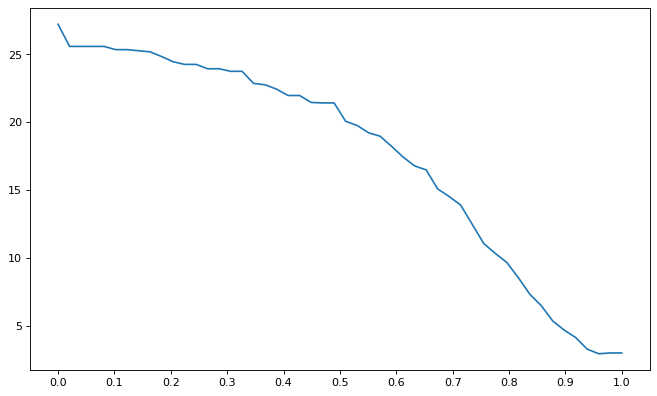

In [15]:
x = res["threshold_levels"]
y = res["agreement_wers"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ])

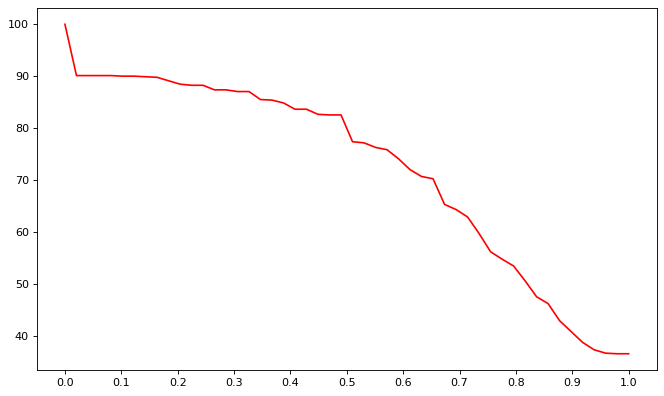

In [16]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_ratios"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ], "r")
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

## Pairwise evaluation

Here we test KB and Google, calculating their WERs under different scenarios (words, phoneme_words, singular phonemes) and also statistics percentages about 
agreement, overlap and mean-lcs

In [20]:
experiment = meval
_filter = {
    "agreement" : False,
    "g_correct" : False,
    "kb_correct" : False,
}
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True
}
res = experiment_repeats(experiment, 5, bunches, "./models/deep-phonemizer-se.pt", **kwargs)
print_experiment_report(res)

  0%|          | 0/5 [00:00<?, ?it/s]

agreement: 0.36553238199780463±0.0
g_correct_kb_not : 0.2768166089965398±0.0
kb_correct_g_not : 0.15051903114186851±0.0
agreement_not_correct: 0.0990990990990991±0.0
both_incorrect_disagreement: 0.5726643598615917±0.0
google_wer: 0.1983669548511047±0.0
kb_wer: 0.19164265129682997±0.0
google-avg-length: 6.300768386388584±0.0
correct-avg-length: 6.856201975850714±0.0
kb-avg-length: 6.711306256860593±0.0
lcs-mean: 0.7239754234570818±0.0
error_index_overlap: 0.3029810298102981±0.0


## Randomness in phonemizer

Here we explore the phenomenon that the phonemizer can output multiple pronounciations of some words, but refrains to do it when it is called with an argument that is List[str]

In [ ]:
phonemizer = phonemizer("Hello my name is nick", lang="se")

In [ ]:
set([phonemizer("ja", "se") for x in range(100)])

In [ ]:
set(phonemizer(["ja" for x in range(10000)], "se"))

# Error analysis

### Sort sentences based on WER  

In [3]:
def bunch_normalized_wer(bunch, model):
    return wer(bunch["correct"], bunch[model]) * len(bunch["correct"].split())

bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]


for bunch in bunch_list:
    bunch["ensemble"] = get_ensemble_output(bunch, None, 0.6, use_phonemizer=False) 
    
sorted_bunch_list = sorted(bunch_list, key=lambda x : bunch_normalized_wer(x,"ensemble"))
sorted_bunch_list.reverse()

In [4]:
wer_sums =  { k : sum(bunch_normalized_wer(x,k) for x in bunch_list) for k in bunch_list[0]}

In [5]:
wer_sums

{'google': 1239.0, 'correct': 0.0, 'kb': 1197.0, 'ensemble': 953.0}

In [6]:
cbunch = sorted_bunch_list[6]

cbunch

curr_wers = {k : bunch_normalized_wer(cbunch,k) for k,v in cbunch.items()}
curr_wers

{'google': 'skulle vi ha gjort det då johan sådär då tänker jag hoppas inte att väggarna ska vara bra isolera du att det liksom',
 'correct': 'skulle vi ha gjort nåt då är ju han så att då tänker ju han på sånt där att väggarna ska vara bra isolerade och att det liksom',
 'kb': 'skulle vi ha gjort nego då är ju han så där att då tänker ju han på sånt där att väggarna ska vara bra isolerade och att liksom',
 'ensemble': 'skulle vi ha gjort nego då johan sådär då tänker ju han på sånt där att väggarna ska vara bra isolera du att  liksom'}

{'google': 13.0, 'correct': 0.0, 'kb': 3.0, 'ensemble': 9.0}

In [7]:
get_kb_google_unmatched_blocks(cbunch)

[('det', 'nego'),
 ('johan sådär', 'är ju han så där att'),
 ('jag hoppas inte', 'ju han på sånt där'),
 ('isolera du', 'isolerade och'),
 ('det', '')]

# Visualization

In [ ]:
idx = 43
size = 10
def get_triad(idx, bunch):
    #### Google, correct, Kb
    return bunch[0][idx], bunch[1][idx], bunch[2][idx]

def plot_triad(triad,ax):
    ax.text(0.0, 0.0, triad[0], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    ax.text(0, -2.5,  triad[2], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(153/255, 51/255, 0/255),
                       fc=(255/255, 153/255, 102/255),
                       )
             )
    ax.text(0, -5,  triad[1], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(42 / 255, 162 / 255, 42 / 255),
                       fc=(133 / 255, 224 / 255, 133 / 255),
                       )
             )
    
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
idx = 0
plot_triad(get_triad(idx, text_data_bunch) ,axs[0])
plot_triad(get_triad(idx, phoneme_data_bunch) ,axs[1])

In [ ]:

def print_triad_correctness(triad):
    #### Google, correct, Kb
    print("Google correct ", triad[1] == triad[0])
    print("KB correct ", triad[1] == triad[2])
    print("Agreement ", triad[0] == triad[2])
    
    print("Google WER ", wer(triad[1], triad[0]))
    print("KB WER ", wer(triad[1], triad[2]))